### Using Maritime Vessel Records to Predict the Weather

For centuries, the crews of ocean-going vessels have maintained essential records onboard known as logbooks. Typically, one of the officers enters a "noon report" each day at noon local time. This entry includes vital information such as the ship's position, course, speed, weather and ocean current conditions, and any special remarks.

Using historical data obtained from maritime vessel logbooks, I will build a model that predicts weather patterns via a Neural Network.

In [7]:
# !pip install geopandas
# !pip install cmocean

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# Necessary Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import geopandas as gpd
import cmocean
import cmocean.cm as cmo
import random
from random import randint
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import matplotlib.gridspec as gridspec
%matplotlib inline


In [10]:
from geopy.geocoders import Nominatim 

To create my model, I will use data from the Climatological Database for the World's Oceans. This data contains over 280,000 noon reports from 1750-1850. Further information can be found at the following link: http://webs.ucm.es/info/cliwoc/

Indeed, as weather science and technology has greatly changed since 1750-1850, the accuracy of the data is not as accurate as it would be today. In this case, it is important to note that the 'Data' in Data Science does not always lead to a perfect science - but we can still use it to gain insights on overall trends and patterns.


In [11]:
df = pd.read_csv('/content/drive/MyDrive/VslLogs1750-1850.csv', low_memory=False)

In [12]:
df.head()

,RecID,InstAbbr,InstName,InstPlace,InstLand,NumberEntry,NameArchiveSet,ArchivePart,Specification,LogbookIdent,LogbookLanguage,EnteredBy,DASnumber,ImageNumber,VoyageFrom,VoyageTo,ShipName,ShipType,Company,OtherShipInformation,Nationality,Name1,Rank1,Name2,Rank2,Name3,Rank3,ZeroMeridian,StartDay,TimeGen,ObsGen,ReferenceCourse,ReferenceWindDirection,DistUnits,DistToLandmarkUnits,DistTravelledUnits,LongitudeUnits,VoyageIni,UnitsOfMeasurement,Calendar,...,Gusts,Rain,Fog,Snow,Thunder,Hail,SeaIce,Duplicate,Release,SSTReading,SSTReadingUnits,StateSea,CurrentDir,CurrentSpeed,TairReading,AirThermReadingUnits,ProbTair,BaroReading,AirPressureReadingUnits,BarometerType,BarTempReading,BarTempReadingUnits,HumReading,HumidityUnits,HumidityMethod,PumpWater,WaterAtThePumpUnits,LifeOnBoard,LifeOnBoardMemo,Cargo,CargoMemo,ShipAndRig,ShipAndRigMemo,Biology,BiologyMemo,WarsAndFights,WarsAndFightsMemo,Illustrations,TrivialCorrection,OtherRem
0,108,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 15",Spanish,NaN,NaN,NaN,ISLA DE ALBIMOR EN LAS GALAPAGOS,PACOCHA,LA ORBE,FRAGATA,NaN,NaN,Spanish,ANTONIO GOMEZ BARREDA,COMANDANTE DE DIVISION,NaN,NaN,NaN,NaN,DESCONOCIDO,Unknown,NaN,Noticia que da Domingo de Orue al Virrey del P...,Unknown,Unknown,DESCONOCIDO,NaN,NaN,360 degrees,18000227.0,NaN,2,...,0,0,0,0,0,0,0,0,CLIWOC Version 1.0,NaN,NaN,MUCHA MAREJADA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,"LA FRAGATA BRETAÑA, DESPUES DE HABER CORRIDO U..."
1,109,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 16",Spanish,NaN,NaN,NaN,DESCONOCIDO (CREO QUE ACAPULCO),SAN BLAS,SAN CARLOS,PAQUEBOTE,NaN,NaN,Spanish,SALVADOR FIDALGO,TENIENTE DE NAVIO,NaN,NaN,NaN,NaN,DESCONOCIDO,Unknown,NaN,"Extracto del tte. Salvador Fidalgo, del San Ca...",Unknown,Unknown,DESCONOCIDO,NaN,NaN,360 degrees,17900203.0,NaN,2,...,0,0,0,0,0,0,0,0,CLIWOC Version 1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,TODOS FONDEADOS SE DEDICAN A PONER UNA BATERIA...
2,110,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 16",Spanish,NaN,NaN,NaN,DESCONOCIDO (CREO QUE ACAPULCO),SAN BLAS,SAN CARLOS,PAQUEBOTE,NaN,NaN,Spanish,SALVADOR FIDALGO,TENIENTE DE NAVIO,NaN,NaN,NaN,NaN,DESCONOCIDO,Unknown,NaN,"Extracto del tte. Salvador Fidalgo, del San Ca...",Unknown,Unknown,DESCONOCIDO,NaN,NaN,360 degrees,17900203.0,NaN,2,...,0,0,0,0,0,0,0,0,CLIWOC Version 1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,TODOS FONDEADOS SE DEDICAN A PONER UNA BATERIA...
3,111,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 16",Spanish,NaN,NaN,NaN,DESCONOCIDO (CREO QUE ACAPULCO),SAN BLAS,SAN CARLOS,PAQUEBOTE,NaN,NaN,Spanish,SALVADOR FIDALGO,TENIENTE DE NAVIO,NaN,NaN,NaN,NaN,DESCONOCIDO,Unknown,NaN,"Extracto del tte. Salvador Fidalgo, del San Ca...",Unknown,Unknown,DESCONOCIDO,NaN,NaN,360 degrees,17900203.0,NaN,2,...,0,0,0,0,0,0,0,0,CLIWOC Version 1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,TODOS FONDEADOS SE DEDICAN A PONER UNA BATERIA...
4,112,MNM,Archivo Museo Naval Madrid,Madrid,Spain,NaN,NaN,NaN,NaN,"MS. 271, doc 16",Spanish,NaN,NaN,NaN,DESCONOCIDO (CREO QUE ACAPULCO),SAN BLAS,SAN CARLOS,PAQUEBOTE,NaN,NaN,Spanish,SALVADOR FIDALGO,TENIENTE DE NAVIO,NaN,NaN,NaN,NaN,DESCONOCIDO,Unknown,NaN,"Extracto del tte. Salvador Fidalgo, del San Ca...",Unknown,Unknown,DESCONOCIDO,NaN,NaN,360 degrees,17900203.0,NaN,2,...,0,0,0,0,0,0,0,0,CLIWOC Version 1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,0,TODOS FONDEADOS SE DEDICAN A PONER UNA BATERIA...


In [13]:
# Data Cleaning - Remove irrelevant columns, drop irrelevant NaNs)
# I am using the Lon3 and Lat3 columns as as they contain the positions 
# already converted to decimal degrees.


df1=df.dropna(subset = ['Lon3', 'Lat3', 'UTC', 'VoyageIni'])
df2=df.dropna(subset = ['VoyageFrom', 'VoyageTo', 'VoyageIni'])
df2 = df2.drop(['RecID', 'InstAbbr', 'InstName', 'InstPlace', 'InstLand', 'NumberEntry', 
                'NameArchiveSet','ArchivePart', 'Specification', 'EnteredBy', 
                'DASnumber', 'ImageNumber', 'OtherShipInformation','Name1', 'Rank1', 'Name2',
                'Rank2', 'Name3', 'Rank3', 'StartDay', 'TimeGen', 'ObsGen', 'DistToLandmarkUnits',
                'DistTravelledUnits', 'LongitudeUnits','VoyageIni', 'UnitsOfMeasurement','Calendar',
                'Calendar', 'DayOfTheWeek', 'PartDay', 'TimeOB', 'Watch', 'Glasses', 'CMG',
                'ShipSpeed', 'drLatDeg','drLatMin',	'drLatSec', 'drLatHem', 'drLongDeg', 
                'drLongMin', 'drLongSec', 'drLongHem', 'LatDeg', 'LatMin', 'LatSec', 'LatHem',
                'LongDeg', 'LongMin', 'LongSec', 'LongHem', 'PosCoastal', 'EncName', 'EncNat', 
                'EncRem', 'Anchored', 'AnchorPlace', 'LMname1', 'LMdirection1', 'LMdistance1', 
                'LMname2', 'LMdirection2', 'LMdistance2', 'LMname3', 'LMdirection3','LMdistance3', 
                'EstError', 'ApplError', 'AllWindDirections', 'ShapeClouds',
                'DirClouds', 'PrecipitationDescriptor','CloudFrac','Duplicate','Release', 'SSTReading',
                'SSTReadingUnits', 'HumReading', 'HumidityUnits', 'HumidityMethod', 'PumpWater', 
                'WaterAtThePumpUnits', 'LifeOnBoard', 'LifeOnBoardMemo', 'CargoMemo', 'ShipAndRig', 
                'ShipAndRigMemo', 'Biology', 'BiologyMemo', 'WarsAndFights', 'WarsAndFightsMemo', 
                'Illustrations', 'TrivialCorrection', 'OtherRem', 'WindScale', 'CurrentDir','CurrentSpeed',
                'BarometerType', 'BarTempReading', 'BarTempReadingUnits', 'WindForceScale', 'Clearness',
                'TairReading', 'AirThermReadingUnits', 'ProbTair', 'BaroReading', 
                'AirPressureReadingUnits', 'LatInd', 'LonInd', 'Company'], axis=1)

In [14]:
df2=df2.dropna(subset = ['Lon3', 'Lat3'])

In [15]:
df2.head()

,LogbookIdent,LogbookLanguage,VoyageFrom,VoyageTo,ShipName,ShipType,Nationality,ZeroMeridian,ReferenceCourse,ReferenceWindDirection,DistUnits,Year,Month,Day,UTC,Distance,Lat3,Lon3,WindDirection,WindForce,AllWindForces,Weather,Gusts,Rain,Fog,Snow,Thunder,Hail,SeaIce,StateSea,Cargo
12,MS. 204,Spanish,EL FERROL,RIO DE LA PLATA,SANTA PERPETUA,FRAGATA,Spanish,TENERIFE,Unknown,Unknown,DESCONOCIDO,1774,3,13,1774031314,131.0,-13.4000,-26.3667,SE1/4E,FRESQUITO,FRESQUITO,HORIZONTES CLAROS,0,0,0,0,0,0,0,LLANA,0
13,MS. 204,Spanish,EL FERROL,RIO DE LA PLATA,SANTA PERPETUA,FRAGATA,Spanish,TENERIFE,Unknown,Unknown,DESCONOCIDO,1774,3,14,1774031414,1355.0,-15.5167,-27.0000,SE1/4E,GALENO,GALENO,HORIZONTES CARGADOS,0,0,0,0,0,0,0,PICADA,0
14,MS. 204,Spanish,EL FERROL,RIO DE LA PLATA,SANTA PERPETUA,FRAGATA,Spanish,TENERIFE,Unknown,Unknown,DESCONOCIDO,1774,3,15,1774031514,95.0,-16.9667,-27.6500,E,FRESQUITO,FRESQUITO,CLARO,0,0,0,0,0,0,0,LLANA,0
15,MS. 204,Spanish,EL FERROL,RIO DE LA PLATA,SANTA PERPETUA,FRAGATA,Spanish,TENERIFE,Unknown,Unknown,DESCONOCIDO,1774,3,16,1774031614,985.0,-18.4000,-28.4167,ENE,BONANCIBLE,BONANCIBLE,HORIZONTES ACELAJADOS,0,0,0,0,0,0,0,LLANA,0
16,MS. 204,Spanish,EL FERROL,RIO DE LA PLATA,SANTA PERPETUA,FRAGATA,Spanish,TENERIFE,Unknown,Unknown,DESCONOCIDO,1774,3,17,1774031714,188.0,-19.8333,-29.0000,ENE,FLOJO,FLOJO,HORIZONTES NUBLADO,0,0,0,0,0,0,0,LLANA,0


In [16]:
# df2.info()

In [17]:
missing_count = (df2.isnull().sum())
print(missing_count[missing_count > 0])

ShipType                  107831
ReferenceCourse            10900
ReferenceWindDirection     10788
DistUnits                  20430
Distance                   84418
WindDirection               5736
WindForce                  22856
AllWindForces              38942
Weather                   164428
StateSea                  195066
dtype: int64


In [18]:
for col in df2.columns:
    if df2[col].isnull().sum() > 0.9*len(df2):
        del df2[col]

In [19]:
# Noticed that there were separate columns for British and English - combining the two).

df2['LogbookLanguage'].value_counts()

Dutch      112594
English     83421
Spanish     45646
French       7687
British        82
Name: LogbookLanguage, dtype: int64

In [20]:
df2[df2['LogbookLanguage']=='British']['Nationality'].value_counts()

British    82
Name: Nationality, dtype: int64

In [21]:
df2.loc[df2['LogbookLanguage']=='British', 'LogbookLanguage'] = 'English'
df2['LogbookLanguage'].value_counts()

Dutch      112594
English     83503
Spanish     45646
French       7687
Name: LogbookLanguage, dtype: int64

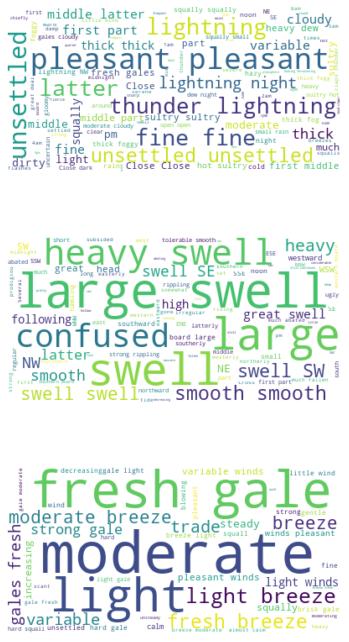

In [22]:
# In this section, I use WordCloud to explore the most common weather descriptions used
# in English (by selecting English vessels). WordCloud is a data visualization technique.
# The size of each word in a WordCloud represents its frequency in a dataset. 

import wordcloud
from wordcloud import WordCloud
from functools import reduce

fig = plt.figure(figsize=(6, 12))
gs1 = gridspec.GridSpec(3, 1)
ax1, ax2, ax3 = fig.add_subplot(gs1[0]),\
                fig.add_subplot(gs1[1]),\
                fig.add_subplot(gs1[2])
        
df3=df2.dropna(subset = ['WindForce','StateSea','Weather'])
df3=df3[df3['Nationality']=='British']

def plotWordCloud(column, df, ax):
    repls = ("weather" , ""), ("sea" , ""), ("water", ""), ("air", ""), ("  ", " ")
    text=" ".join(df[column].tolist())
    text=reduce(lambda a, kv: a.replace(*kv), repls, text)
    wordcloud = WordCloud(background_color="white").generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

plotWordCloud('Weather', df3, ax1)
plotWordCloud('StateSea', df3, ax2)
plotWordCloud('WindForce', df3, ax3)

In [23]:
# In this section, I will use GeoPandas. GeoPandas is a library
# that makes working with geospatial data in Python easier.
# It extends the datatypes used by Pandas to allow spatial operations
# on geometric types.

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

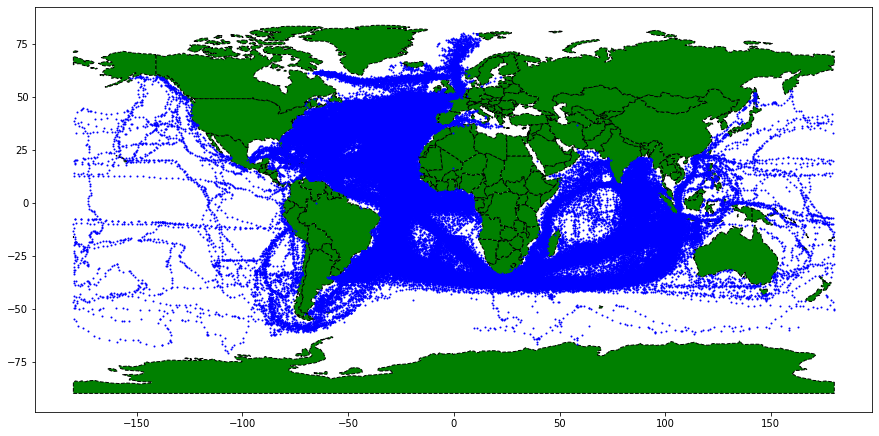

In [24]:
# Here, I am using the positions from Lat3 and Lon3 to find where most ocean
# voyages took place between 1750 and 1850. As we can see below, the most heavily
# trafficked areas were the N. and S. Atlantic and Indian Ocean. 

axworld = world.plot(figsize=(15,20), color = 'green', linestyle='dashed', edgecolor ='black')
gpd_all = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2['Lon3'], df2['Lat3']), crs = 4326)
gpd_all.plot(markersize=1, color = 'blue', ax=axworld)

In [25]:
# Now that I have all of the noon positions plotted, I can explore the data further by
# examining particular weather features. In each of the noon reports, a certain type of
# weather event was reported. This can be plotted against all positions.

shipdata = df2

def weather_event(feature, feature_val, fcol):
    dfselect = shipdata[shipdata[feature]==feature_val]
    axworld = world.plot(figsize=(15,20), color = 'green', linestyle='dashed', edgecolor ='black')
    gpd_all = gpd.GeoDataFrame(shipdata, geometry=gpd.points_from_xy(shipdata['Lon3'], shipdata['Lat3']), crs = 4326)
    gpd_all.plot(markersize=1, color = 'lightgray', ax=axworld)
    gpd_each = gpd.GeoDataFrame(dfselect, geometry=gpd.points_from_xy(dfselect['Lon3'], dfselect['Lat3']), crs = 4326)
    if not dfselect.empty:
        gpd_each.plot(markersize=2, color = fcol, ax=axworld)
    return

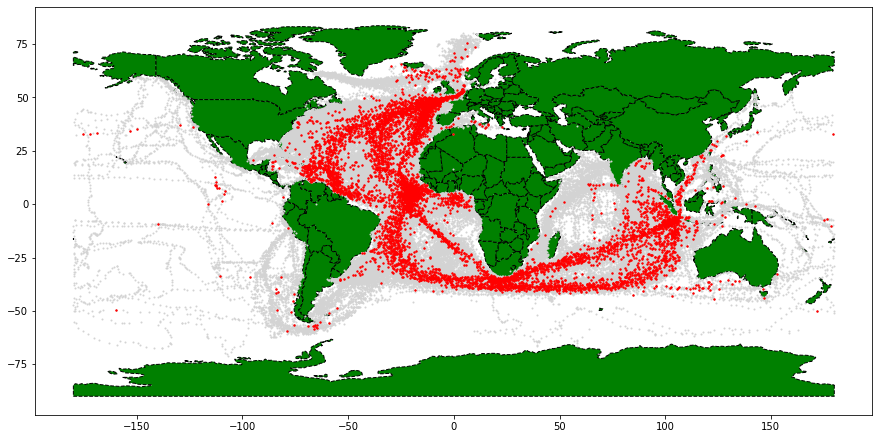

In [26]:
weather_event('Gusts', 1, 'red')

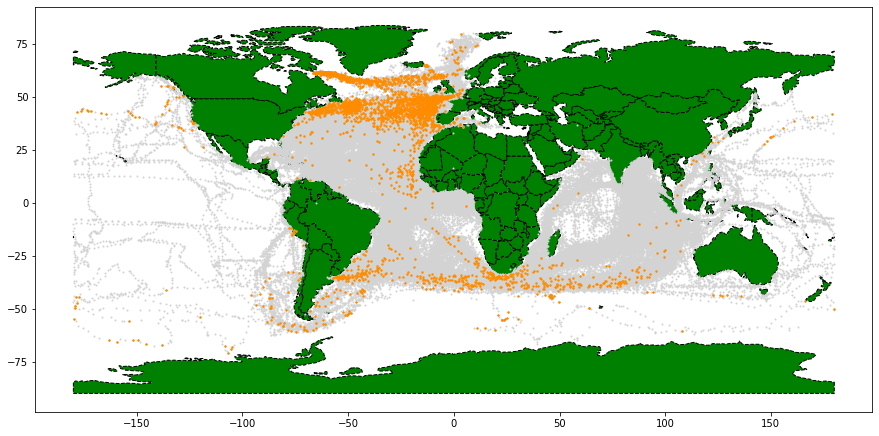

In [27]:
weather_event('Fog', 1, 'darkorange')

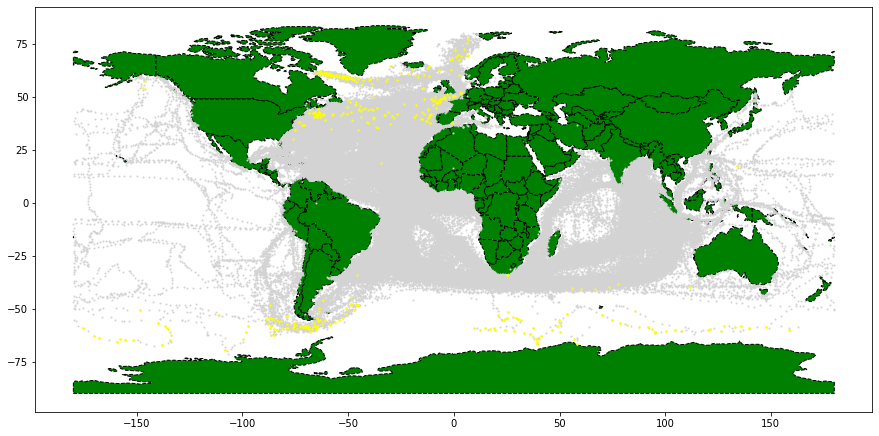

In [28]:
weather_event('Snow', 1, 'yellow')

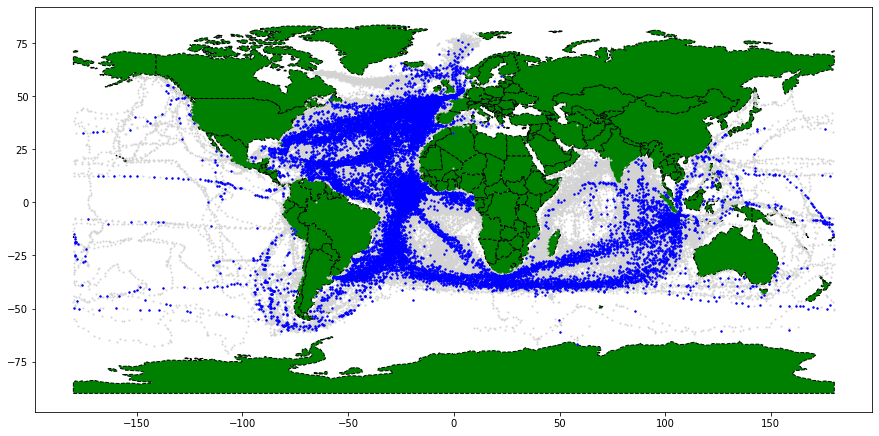

In [29]:
weather_event('Rain', 1, 'blue')

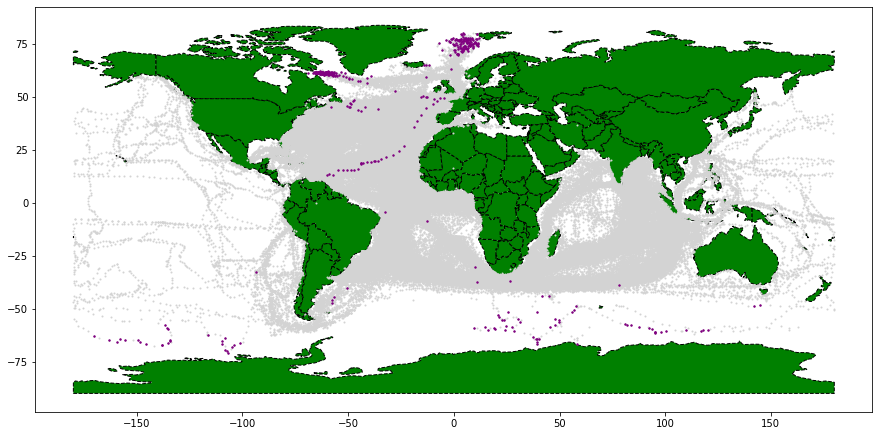

In [30]:
weather_event('SeaIce', 1, 'purple')

In [31]:
### Neural Network

# To assist in neural network implemenation, I will employ Theano.
# Theano is a Python library used in Deep Learning projects. It was developed 
# by the Montreal Institute for Learning Algorithms 
# at the Université de Montréal. It is an optimizing compiler
# for manipulating and evaluating mathematical expressions, including multi-dimensional arrays.

# By using a neural network with Theano, I will be able to predict weather conditions 
# basis elements such as position and date. 

import theano
import theano.tensor as T
import theano.tensor.nnet as nnet
from sklearn.metrics import log_loss

In [32]:
# Required columns for weather prediction

df5=df[['Lon3', 'Lat3', 'Year', 'Month', 'Gusts', 'Rain', 'Fog', 'Snow', 'Thunder', 'Hail', 'SeaIce']]
df5=df5.dropna()

# Below is a function to determine whether or not the weather was sunny.
# By adding the 'Sun' column, this will be used/filled out when no other weather event was reported.
# This is a valid assumption because as seen in the WordClouds, "pleasant/light/fresh" conditions
# were often observed. 

def sunny(row):
    if row['sum'] == 0:
        val = 1
    else:
        val= 0
    return val

df5['sum'] = df5[['Gusts', 'Rain', 'Fog', 'Snow', 'Thunder', 'Hail', 'SeaIce']].sum(axis=1)
df5['Sun'] = df5.apply(sunny, axis=1)

# Normalize the features to ensure that each will have the same weight; they will have zero mean and
# variance equal to one. 

for column in ['Lon3', 'Lat3', 'Year', 'Month']:
        df5[column]=(df5[column]-df5[column].mean(axis=0))/df5[column].std(axis=0)

# Next, I will split the dataset: 80% training, 10% testing, 10% validation

dfTrain=df5.sample(n=1000,random_state=20)
dfVal=df5.drop(dfTrain.index).sample(n=125,random_state=50)
dfTest=df5.drop(dfTrain.index).drop(dfVal.index).sample(n=125,random_state=80)

# Here I change the format of the data and put it into matrices
xTrain=dfTrain[['Lon3', 'Lat3', 'Year', 'Month']].to_numpy() 
yTrain=dfTrain[['Gusts', 'Rain', 'Fog', 'Snow', 'Thunder', 'Hail', 'SeaIce', 'Sun']].to_numpy()
xVal=dfVal[['Lon3', 'Lat3', 'Year', 'Month']].to_numpy() 
yVal=dfVal[['Gusts', 'Rain', 'Fog', 'Snow', 'Thunder', 'Hail', 'SeaIce', 'Sun']].to_numpy()
xTest=dfTest[['Lon3', 'Lat3', 'Year', 'Month']].to_numpy() 
yTest=dfTest[['Gusts', 'Rain', 'Fog', 'Snow', 'Thunder', 'Hail', 'SeaIce', 'Sun']].to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
np.random.seed(1)

# Define input tensors (a vector or matrix of n-dimensions that represents
# all types of data)

x = T.dvector()
y = T.dvector()

# Below is a layer function that takes an input vector x
# and a vector containing the weights w.
# A bias node b is added in case the activation function (sigmoid)
# needs to be shifted.

def layer(x, w):
    b = np.array([1], dtype=theano.config.floatX)
    new_x = T.concatenate([x, b])
    m = T.dot(w.T, new_x) 
    h = nnet.sigmoid(m)
    return h

# Define a function to update the weights through a gradient
# descent optimization. Alpha represents the learning rate

def grad_desc(cost, theta):
    alpha = 0.3
    return theta - (alpha * T.grad(cost, wrt=theta))

# Define the weights for the input and the hidden layer, which are initialized randomly

theta1 = theano.shared(np.array(np.random.rand(xTrain.shape[1]+1,xTrain.shape[1]+1),\
                                dtype=theano.config.floatX)) 
theta2 = theano.shared(np.array(np.random.rand(xTrain.shape[1]+2,yTrain.shape[1]),\
                                dtype=theano.config.floatX))

# Build the hidden and ouput layers
hid1 = layer(x, theta1)
out1 = layer(hid1, theta2) 

# Cost and accuracy functions

cost = T.mean(T.nnet.binary_crossentropy(out1, y))

acc= T.mean(T.isclose(out1, y, rtol=1e-01, atol=1e-02))

# Theano functions

# Train the network, adjusting the weights
# according to the gradient descent and the cost function

train = theano.function(inputs=[x, y], outputs=[cost,acc], updates=[
        (theta1, grad_desc(cost, theta1)),
        (theta2, grad_desc(cost, theta2))])

valid = theano.function(inputs=[x, y], outputs=[cost,acc])

test = theano.function(inputs=[x, y], outputs=acc)

run_forward = theano.function(inputs=[x], outputs=out1)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [34]:
# Now to run the Neural Network

epochs=2500 

meanTrain, meanVal=[],[] 

for i in range(epochs+1):
    trainOut,valOut=[],[]
    for k in range(len(xTrain)):
        trainOut.append(train(xTrain[k], yTrain[k])) 
    for k in range(len(xVal)):
	    valOut.append(valid(xVal[k], yVal[k]))
    meanTrain.append(np.mean([[x,y] for x,y in trainOut], axis=0))
    meanVal.append(np.mean([[x,y] for x,y in valOut], axis=0))
    if i % 500 == 0: # Print every 500th cycle 
	    print(' Mean Cost Training: %s' % meanTrain[i][0])
	    print(' Mean Accuracy Training: %s' % meanTrain[i][1])
	    print(' Mean Cost Validation: %s' % meanVal[i][0])
	    print(' Mean Accuracy Validation: %s' % meanVal[i][1])
	    print('---------------------------------------')


 Mean Cost Training: 0.17086419987287116
 Mean Accuracy Training: 0.1595
 Mean Cost Validation: 0.1297019594250425
 Mean Accuracy Validation: 0.374
---------------------------------------
 Mean Cost Training: 0.10908643633939158
 Mean Accuracy Training: 0.630375
 Mean Cost Validation: 0.13883354426104316
 Mean Accuracy Validation: 0.614
---------------------------------------
 Mean Cost Training: 0.10853674860147733
 Mean Accuracy Training: 0.64325
 Mean Cost Validation: 0.1431406332584055
 Mean Accuracy Validation: 0.646
---------------------------------------
 Mean Cost Training: 0.10828039543338192
 Mean Accuracy Training: 0.647
 Mean Cost Validation: 0.14546120358148282
 Mean Accuracy Validation: 0.649
---------------------------------------
 Mean Cost Training: 0.1081178371860399
 Mean Accuracy Training: 0.649
 Mean Cost Validation: 0.14703814742272597
 Mean Accuracy Validation: 0.654
---------------------------------------
 Mean Cost Training: 0.1080007226213335
 Mean Accuracy Tr

(<matplotlib.legend.Legend at 0x7f420a8f9c50>,
 <matplotlib.legend.Legend at 0x7f420b190710>)

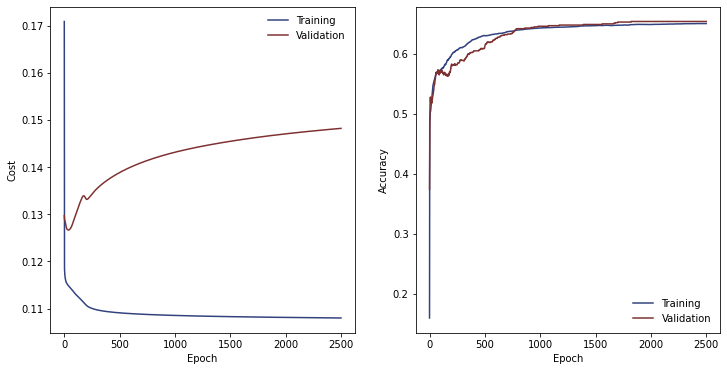

In [35]:
# Next, I will plot the trends to evaluate if there is improvement
# during training


fig = plt.figure(figsize=(12, 6))
gs1 = gridspec.GridSpec(1, 2)
ax1, ax2 = fig.add_subplot(gs1[0]),\
                fig.add_subplot(gs1[1])  

ax1.plot([x for x,y in meanTrain], color='#31427e', label='Training')
ax1.plot([x for x,y in meanVal], color='#7e3131', label='Validation')
ax2.plot([y for x,y in meanTrain], color='#31427e', label='Training')
ax2.plot([y for x,y in meanVal], color='#7e3131', label='Validation')

ax1.set_xlabel('Epoch'), ax2.set_xlabel('Epoch')    
ax1.set_ylabel('Cost'), ax2.set_ylabel('Accuracy')
ax1.legend(frameon=False),ax2.legend(frameon=False)

In [36]:
# Calculate final accuracy: 

print('==================================')
finAcc=[]
for k in range(len(xTest)):
	finAcc.append(test(xTest[k], yTest[k]))
print( ' Final Accuracy: %s' % np.mean(finAcc))
print('==================================')

 Final Accuracy: 0.629


In [50]:
train(xTrain[0], yTrain[0])

[array(0.0286407), array(0.75)]

In [54]:
train(xTrain[1], yTrain[1])

[array(0.05038181), array(0.625)]

In [58]:
xTrain[3], yTrain[3]

(array([-0.08365559,  1.43706868, -0.65992795,  0.5072356 ]),
 array([1, 1, 0, 0, 0, 0, 0, 0]))

In [38]:
# import pickle
# path = '/content/drive/MyDrive/Colab Notebooks/Logbook_Weather_Prediction/'

# pickle_out = open(path + 'model.pkl', 'wb')
# pickle.dump(train, pickle_out)
# pickle_out.close()